In [1]:
import gymnasium as gym
import highway_env
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import pickle
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from copy import deepcopy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Load config
with open("configs/config.pkl", "rb") as f:
    config = pickle.load(f)

env = gym.make("highway-fast-v0", render_mode=None, config=config)
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, done, next_state):
        self.buffer.append((state, action, reward, done, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, done, next_state = map(np.array, zip(*batch))
        return state, action, reward, done, next_state

    def __len__(self):
        return len(self.buffer)

In [5]:
class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
        )

    def forward(self, x):
        return self.net(x)

In [6]:
class DQN_Skeleton:
    def __init__(self,
                 action_space,
                 observation_space,
                 gamma,
                 batch_size,
                 buffer_capacity,
                 update_target_every,
                 epsilon_start,
                 decrease_epsilon_factor,
                 epsilon_min,
                 learning_rate,
                 hidden_size,
                ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma

        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every

        self.epsilon_start = epsilon_start
        self.decrease_epsilon_factor = decrease_epsilon_factor
        self.epsilon_min = epsilon_min

        self.learning_rate = learning_rate
        self.hidden_size = hidden_size

        self.reset()

    def get_q(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).flatten().unsqueeze(0).to(device)
        with torch.no_grad():
            output = self.q_net.forward(state_tensor)
        return output.cpu().numpy()[0]

    def get_action(self, state, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon

        if np.random.rand() < epsilon:
            return self.action_space.sample()
        else:
            return np.argmax(self.get_q(state))
        
    def update(self, state, action, reward, done, next_state):
        self.buffer.push(state, action, reward, done, next_state)

        if len(self.buffer) < self.batch_size:
            return None

        states, actions, rewards_, dones, next_states = self.buffer.sample(self.batch_size)

        states = torch.FloatTensor(states).view(states.shape[0], -1).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards_ = torch.FloatTensor(rewards_).unsqueeze(1).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).view(next_states.shape[0], -1).to(device)

        q_values = self.q_net(states).gather(1, actions)
        next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
        targets = rewards_ + self.gamma * next_q_values * (1 - dones)

        loss = self.loss_function(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.n_steps % self.update_target_every == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        self.n_steps += 1
        if done:
            self.n_eps += 1
            self.decrease_epsilon()

        return loss.item()
    
    def decrease_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
            np.exp(-1.0 * self.n_eps / self.decrease_epsilon_factor)
        )

    def reset(self):
        hidden_size = self.hidden_size
        obs_size = int(np.prod(self.observation_space.shape))
        n_actions = self.action_space.n

        self.buffer = ReplayBuffer(self.buffer_capacity)
        self.q_net = Net(obs_size, hidden_size, n_actions).to(device)
        self.target_net = Net(obs_size, hidden_size, n_actions).to(device)


        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.learning_rate)

        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0

In [7]:
def eval_agent(agent, env, n_sim=5):
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)

    for i in range(n_sim):
        state, _ = env_copy.reset()
        done = False
        reward_sum = 0

        while not done:
            action = agent.get_action(state, epsilon=0)  # no exploration
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated

        episode_rewards[i] = reward_sum

    return episode_rewards

In [8]:
def train(env, agent, N_episodes, eval_every=10, reward_threshold=300):
    total_time = 0
    losses = []
    reward_history = []

    for ep in range(N_episodes):
        state, _ = env.reset()
        done = False

        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            loss_val = agent.update(state, action, reward, terminated, next_state)

            state = next_state
            done = terminated or truncated
            total_time += 1

            if loss_val is not None:
                losses.append(loss_val)

        if (ep + 1) % eval_every == 0:
            rewards = eval_agent(agent, env)
            avg_reward = np.mean(rewards)
            reward_history.append(avg_reward)
            print(f"episode {ep+1}, reward = {avg_reward:.2f}, epsilon = {agent.epsilon:.3f}")

            if avg_reward >= reward_threshold:
                print("Stopping early — reward threshold reached.")
                break

    return losses, reward_history

In [9]:
hidden_size = 128
buffer_capacity = 20000
batch_size = 64
gamma = 0.99
epsilon_start = 0.9
epsilon_min = 0.05
decrease_epsilon_factor = 1000
update_target_every = 200
learning_rate = 1e-4

In [10]:
agent = DQN_Skeleton(
    action_space=env.action_space,
    observation_space=env.observation_space,
    gamma=gamma,
    batch_size=batch_size,
    buffer_capacity=buffer_capacity,
    update_target_every=update_target_every,
    epsilon_start=epsilon_start,
    decrease_epsilon_factor=decrease_epsilon_factor,
    epsilon_min=epsilon_min,
    learning_rate=learning_rate,
    hidden_size=hidden_size
)

N_episodes = 300
losses, rewards = train(env, agent, N_episodes=300)

episode 10, reward = 12.76, epsilon = 0.895
episode 20, reward = 38.66, epsilon = 0.887
episode 30, reward = 48.32, epsilon = 0.879
episode 40, reward = 45.01, epsilon = 0.871
episode 50, reward = 41.67, epsilon = 0.863
episode 60, reward = 38.59, epsilon = 0.855
episode 70, reward = 26.11, epsilon = 0.847
episode 80, reward = 43.77, epsilon = 0.839
episode 90, reward = 47.50, epsilon = 0.832
episode 100, reward = 34.91, epsilon = 0.825
episode 110, reward = 51.99, epsilon = 0.818
episode 120, reward = 47.85, epsilon = 0.811
episode 130, reward = 44.85, epsilon = 0.805
episode 140, reward = 45.43, epsilon = 0.799
episode 150, reward = 51.25, epsilon = 0.792
episode 160, reward = 48.24, epsilon = 0.785
episode 170, reward = 37.75, epsilon = 0.777
episode 180, reward = 44.89, epsilon = 0.771
episode 190, reward = 43.52, epsilon = 0.764
episode 200, reward = 48.77, epsilon = 0.757
episode 210, reward = 36.44, epsilon = 0.751
episode 220, reward = 48.75, epsilon = 0.745
episode 230, reward

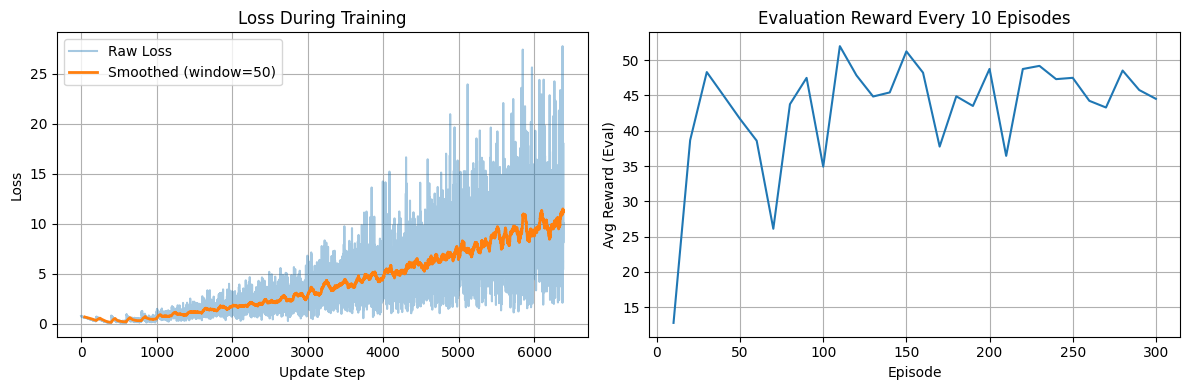

In [21]:
# Plot losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

# Original (noisy) loss curve
plt.plot(losses, label="Raw Loss", alpha=0.4)

# Smoothed loss curve (moving average)
window = 50
if len(losses) >= window:
    smoothed_losses = np.convolve(losses, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, window-1 + len(smoothed_losses)), smoothed_losses, label=f"Smoothed (window={window})", linewidth=2)

plt.xlabel("Update Step")
plt.ylabel("Loss")
plt.title("Loss During Training")
plt.legend()
plt.grid()

# Plot rewards
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(rewards)+1) * 10, rewards, label="Eval Reward")
plt.xlabel("Episode")
plt.ylabel("Avg Reward (Eval)")
plt.title("Evaluation Reward Every 10 Episodes")
plt.grid()

plt.tight_layout()
plt.show()

In [12]:
print("Rewards after training = ", eval_agent(agent, env))

Rewards after training =  [37.50473934 43.75473934 56.25473934 43.75473934 41.358906  ]


In [13]:
test_rewards = eval_agent(agent, env, n_sim=20)
print("Average Test Reward:", np.mean(test_rewards))

Average Test Reward: 43.18649083882351


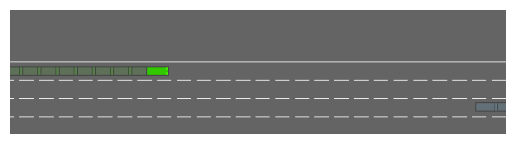

In [23]:
env = gym.make("highway-fast-v0", render_mode="rgb_array", config=config)
state, _ = env.reset()
done = False

for _ in range(100):
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).flatten().unsqueeze(0).to(device)
        action = torch.argmax(agent.q_net(state_tensor)).item()
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    clear_output(wait=True)
    plt.show()
    time.sleep(0.1)
env.close()